# SageMaker Realtime Inference Llama 2 7B chat HF TGI using response streaming

## Set up development environment

Upgrade `pip` and install the latest version of `sagemaker` and `boto3` packages.

In [ ]:
!pip install -Uq pip
!pip install -Uq boto3 sagemaker

Restore the `endpoint_name` from the deployment notebook.

In [ ]:
%store -r \
endpoint_name

In [ ]:
endpoint_name

## Setup Code for Realtime Inference for response streaming

Amazon SageMaker's new `InvokeEndpointWithResponseStream` API allows developers to stream responses back from SageMaker models, which can help to improve customer satisfaction by reducing the perceived latency. This is especially important for applications built with generative AI models, where immediate processing is more important than waiting for the entire response.

The `LineIterator` helper class will parse the response stream received from the inference request made via `InvokeEndpointWithResponseStream` API.

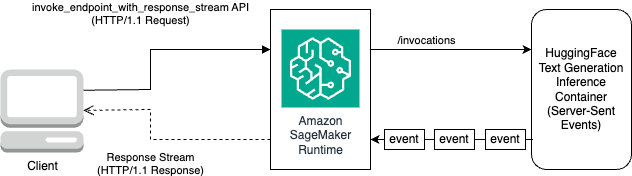

In [ ]:
import boto3
from utils.LineIterator import LineIterator
import json
sagemaker_runtime = boto3.client('sagemaker-runtime')

In [ ]:
def get_realtime_response_stream(sagemaker_runtime, endpoint_name, payload):
    response_stream = sagemaker_runtime.invoke_endpoint_with_response_stream(
        EndpointName=endpoint_name,
        Body=json.dumps(payload), 
        ContentType="application/json",
        CustomAttributes='accept_eula=true'
    )
    return response_stream

def print_response_stream(response_stream):
    event_stream = response_stream['Body']
    start_json = b'{'
    stop_token = '</s>'
    for line in LineIterator(event_stream):
        if line != b'' and start_json in line:
            data = json.loads(line[line.find(start_json):].decode('utf-8'))
            if data['token']['text'] != stop_token:
                print(data['token']['text'],end='')

## Prepare Prompt and instructions

To prompt Llama 2 Chat, you need to have following prompt format

```
<s>[INST] <<SYS>>
{{ system_prompt }}
<</SYS>>

{{ user_message }} [/INST]
```

In [ ]:
def build_llama2_prompt(instructions):
    stop_token = "</s>"
    start_token = "<s>"
    startPrompt = f"{start_token}[INST] "
    endPrompt = " [/INST]"
    conversation = []
    for index, instruction in enumerate(instructions):
        if instruction["role"] == "system" and index == 0:
            conversation.append(f"<<SYS>>\n{instruction['content']}\n<</SYS>>\n\n")
        elif instruction["role"] == "user":
            conversation.append(instruction["content"].strip())
        else:
            conversation.append(f"{endPrompt} {instruction['content'].strip()} {stop_token}{startPrompt}")

    return startPrompt + "".join(conversation) + endPrompt

In [ ]:
def get_instructions(user_content):
    
    '''
    Note: We are creating a fresh user content everytime by initializing instructions for every user_content.
    This is to avoid past user_content when you are inferencing multiple times with new ask everytime.
    ''' 
    
    system_content = '''
    You are a friendly and knowledgeable email marketing agent, Mr.MightyMark, working at AnyCompany. 
    Your goal is to send email to subscribers to help them understand the value of the new product and generate excitement for the launch.

    Here are some tips on how to achieve your goal:

    Be personal. Address each subscriber by name and use a friendly and conversational tone.
    Be informative. Explain the key features and benefits of the new product in a clear and concise way.
    Be persuasive. Highlight how the new product can solve the subscriber's problems or improve their lives.
    Be engaging. Use emojis to make your emails more visually appealing and interesting to read.

    By following these tips, you can use email marketing to help your company launch a successful software product.
    '''

    instructions = [
        { "role": "system","content": f"{system_content} "},
    ]
    
    instructions.append({"role": "user", "content": f"{user_content}"})
    
    return instructions


## Inference the Llama 2 7B chat HF TGI SageMaker endpoint for Streaming Response

### Inference example 1

In [ ]:
user_ask_1 = f'''
AnyCompany recently announced new service launch named AnyCloud Internet Service.
Write a short email about the product launch with Call to action to Alice Smith, whose email is alice.smith@example.com
Mention the Coupon Code: EARLYB1RD to get 20% for 1st 3 months.
'''
instructions = get_instructions(user_ask_1)
prompt = build_llama2_prompt(instructions)
print(prompt)

In [ ]:
inference_params = {
        "do_sample": True,
        "top_p": 0.6,
        "temperature": 0.9,
        "top_k": 50,
        "max_new_tokens": 512,
        "repetition_penalty": 1.03,
        "stop": ["</s>"],
        "return_full_text": False
    }

payload = {
    "inputs":  prompt,
    "parameters": inference_params,
    "stream": True ## <-- to have response stream.
}

As we are interested in streaming response, the request payload must provide a key value pair with **"stream": True**

In [ ]:
resp = get_realtime_response_stream(sagemaker_runtime, endpoint_name, payload)
print_response_stream(resp)

### Inference example 2

In [ ]:
user_ask_2 = f'''
AnyCompany recently announced new service launch named AnyCloud Streaming Service.
Write a short email about the product launch with Call to action to Alice Smith, whose email is alice.smith@example.com
Mention the Coupon Code: STREAM2DREAM to get 15% for 1st 6 months.
'''

instructions = get_instructions(user_ask_2)
prompt = build_llama2_prompt(instructions)

inference_params = {
        "do_sample": True,
        "top_p": 0.6,
        "temperature": 0.9,
        "top_k": 50,
        "max_new_tokens": 512,
        "repetition_penalty": 1.03,
        "stop": ["</s>"],
        "return_full_text": False
    }

payload = {
    "inputs":  prompt,
    "parameters": inference_params,
    "stream": True ## <-- to have response stream.
}

resp = get_realtime_response_stream(sagemaker_runtime, endpoint_name, payload)
print_response_stream(resp)

## Clean Up

Finally, let's programatically clean up SageMaker Endpoint, EndpointConfig and Model

Change the value of the variable *cleanup* to `True` to perform clean up activity.

In [ ]:
cleanup = False

In [ ]:
import boto3
sm_client = boto3.client('sagemaker')
endpoint = sm_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_config_name = endpoint['EndpointConfigName']
endpoint_config = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
model_name = endpoint_config['ProductionVariants'][0]['ModelName']

print(f"""
About to delete the following sagemaker resources:
Endpoint: {endpoint_name}
Endpoint Config: {endpoint_config_name}
Model: {model_name}
""")

In [ ]:
if cleanup:
    # delete endpoint
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    # delete endpoint config
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    # delete model
    sm_client.delete_model(ModelName=model_name)

## References:
1. [Sagemaker Real-time Inference now supports response streaming](https://aws.amazon.com/about-aws/whats-new/2023/09/sagemaker-real-time-inference-response-streaming/)
2. [Elevating the generative AI experience: Introducing streaming support in Amazon SageMaker hosting](https://aws.amazon.com/blogs/machine-learning/elevating-the-generative-ai-experience-introducing-streaming-support-in-amazon-sagemaker-hosting/)